# eICU Models

In [111]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import statsmodels.api as statm
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import umap
import random
import sqlite3
import time
import os
print(os.getcwd())

# Plot settings
%matplotlib inline
plt.style.use('ggplot')
fontsize = 20 # size for x and y ticks
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams.update({'font.size': fontsize})

/Users/mengphilshen/Dropbox/Warehouse/eICU


## Data Source
The eICU Collaborative Research Database, a multi-center intensive care unit (ICU)database with high granularity data for over 200,000 admissions to ICUs monitored by eICU Programs across the United States.

## Patient Selection

* Patient ICU Stays identified through Sepsis diagnosis
* Patient without missing ICU Discharge Status 
* Patient admission from 2014 through 2015
* Patient 18 years and older
* Patient with valid demographic information
* Patient with APACHE score

## Mortality Risk Model

### Preprocess Data

In [2]:
# Load intermediate datasets
sep_patient3 = pd.read_csv('/Users/mengphilshen/Dropbox/Warehouse/eICU/intermediate_data/sep_patient3.csv')
sep_apache3 = pd.read_csv('/Users/mengphilshen/Dropbox/Warehouse/eICU/intermediate_data/sep_apache3.csv')

In [3]:
# Select patient variables
patient_var0 = sep_patient3[['patientunitstayid', 'age_group', 'ethnicity2', 'gender']]
patient_var1 = pd.get_dummies(patient_var0)
patient_var1 = patient_var1.drop(['gender_Male', 'age_group_18-35', 'ethnicity2_African American'], axis = 1)
patient_var1.head()

,patientunitstayid,age_group_36-65,age_group_66-89,age_group_89+,ethnicity2_Asian,ethnicity2_Caucasian,ethnicity2_Hispanic,ethnicity2_Native American,ethnicity2_Other/Unknown,gender_Female
0,141227,0,1,0,0,1,0,0,0,0
1,141288,1,0,0,0,1,0,0,0,1
2,141304,0,1,0,0,1,0,0,0,0
3,141392,0,1,0,0,1,0,0,0,1
4,141462,0,1,0,0,1,0,0,0,0


In [4]:
# Select apache variables
apache_var0 = sep_apache3.drop(['actualiculos'], axis = 1)
def func(x):
    if x == "EXPIRED":
        return 1
    else:
        return 0
apache_var0['icumortality'] = apache_var0['actualicumortality'].apply(func)
apache_var1 = apache_var0.drop(['actualicumortality', 'acutephysiologyscore'], axis = 1)
apache_var1.head()

,patientunitstayid,apachescore,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,...,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,ima,midur,diabetes,icumortality
0,141227,100,-1.0,42.7,40.1,54.0,133.0,204,198,7.46,...,0,0,0,0,0,0,0,0,0,0
1,141288,33,-1.0,16.3,36.6,46.0,140.0,105,64,7.37,...,0,0,0,0,0,0,0,0,0,0
2,141304,67,-1.0,12.8,36.6,28.0,140.0,120,60,-1.00,...,0,0,0,0,1,0,0,0,0,0
3,141392,35,-1.0,17.5,36.6,22.0,137.0,82,118,-1.00,...,0,0,0,0,0,0,0,0,1,0
4,141462,53,-1.0,14.5,36.6,55.0,132.0,102,64,-1.00,...,0,0,0,0,0,0,0,0,1,0


In [5]:
# Merge dataset
merged_data = pd.merge(patient_var1, apache_var1, on = 'patientunitstayid')
merged_data.set_index(['patientunitstayid'], inplace = True) 
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17545 entries, 141227 to 3353251
Data columns (total 46 columns):
age_group_36-65               17545 non-null uint8
age_group_66-89               17545 non-null uint8
age_group_89+                 17545 non-null uint8
ethnicity2_Asian              17545 non-null uint8
ethnicity2_Caucasian          17545 non-null uint8
ethnicity2_Hispanic           17545 non-null uint8
ethnicity2_Native American    17545 non-null uint8
ethnicity2_Other/Unknown      17545 non-null uint8
gender_Female                 17545 non-null uint8
apachescore                   17545 non-null int64
urine                         17545 non-null float64
wbc                           17545 non-null float64
temperature                   17545 non-null float64
respiratoryrate               17545 non-null float64
sodium                        17545 non-null float64
heartrate                     17545 non-null int64
meanbp                        17545 non-null int64
ph     

In [93]:
# Save merged_data
merged_data.to_csv('/Users/mengphilshen/Dropbox/Warehouse/eICU/intermediate_data/merged_data.csv')

In [6]:
# Seperate class
Y = merged_data.iloc[:, merged_data.columns == 'icumortality']
Y['icumortality'].value_counts()

0    15565
1     1980
Name: icumortality, dtype: int64

In [7]:
# Seperate features
X = merged_data.iloc[:, merged_data.columns != 'icumortality']
X.describe() 

,age_group_36-65,age_group_66-89,age_group_89+,ethnicity2_Asian,ethnicity2_Caucasian,ethnicity2_Hispanic,ethnicity2_Native American,ethnicity2_Other/Unknown,gender_Female,apachescore,...,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,ima,midur,diabetes
count,17545.000000,17545.000000,17545.00000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.00000,17545.000000,...,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000
mean,0.403363,0.487831,0.04896,0.016586,0.776803,0.047250,0.008492,0.053121,0.48538,68.487717,...,0.002622,0.019094,0.008093,0.029752,0.014192,0.052038,0.025021,0.001368,0.005529,0.241550
std,0.490586,0.499866,0.21579,0.127717,0.416402,0.212179,0.091765,0.224280,0.49980,27.772305,...,0.051138,0.136859,0.089601,0.169907,0.118286,0.222109,0.156194,0.036961,0.074151,0.428035
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,49.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,65.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,84.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,211.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


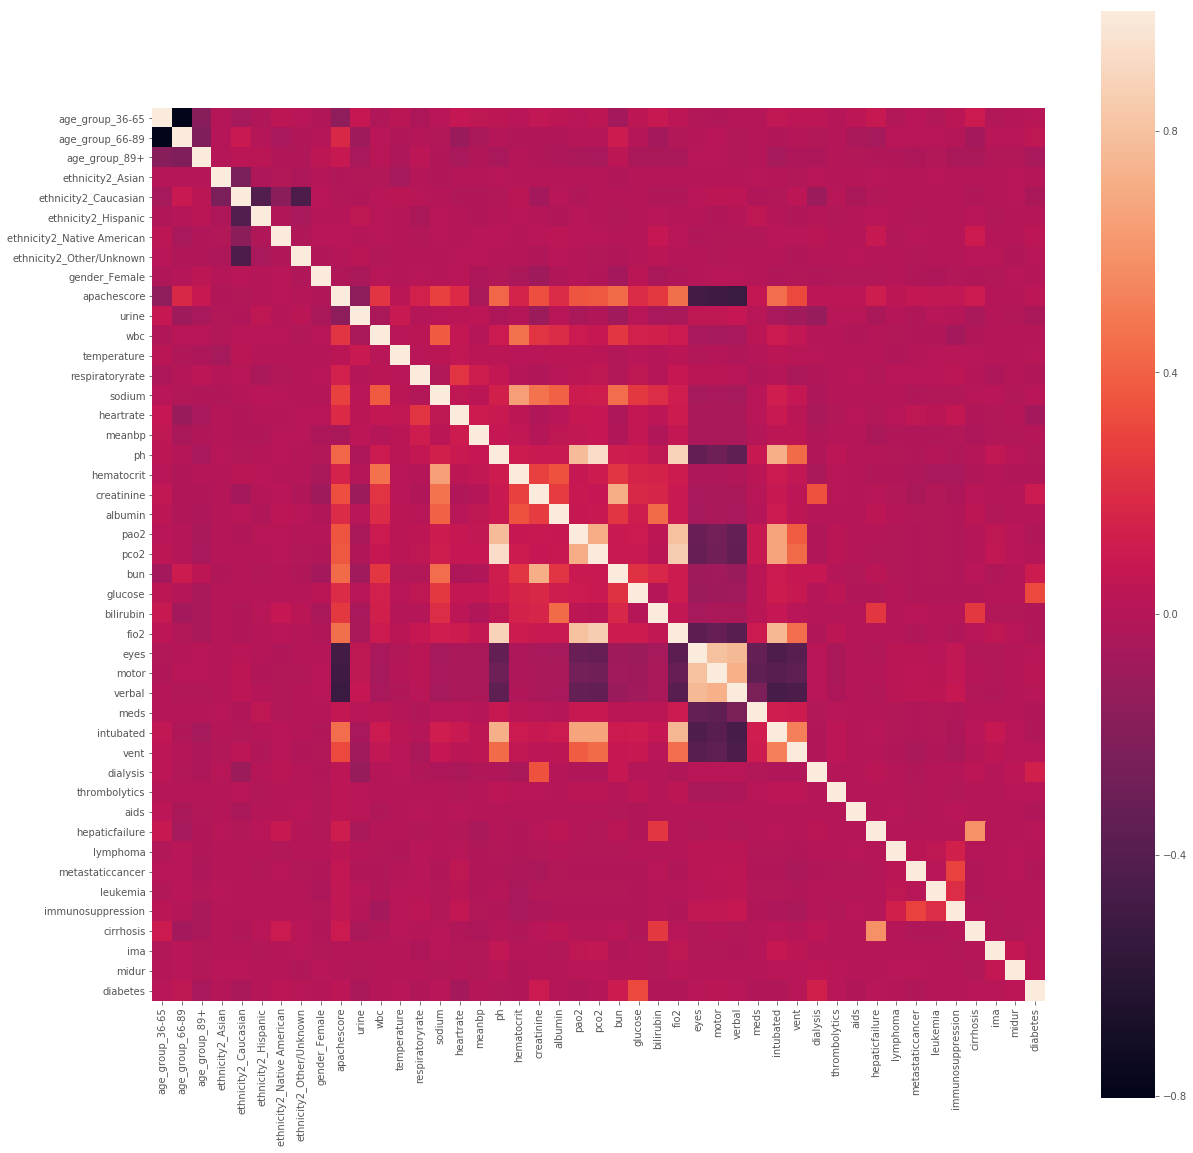

In [8]:
# Check correlations
corrmat = X.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, square = True)
plt.show()

### Split training and test set

In [113]:
# Split into the training set and test set
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.30, random_state = 42)
print('Training Features Shape:', train_X.shape)
print('Training Labels Shape:', train_Y.shape)
print('Testing Features Shape:', test_X.shape)
print('Testing Labels Shape:', test_Y.shape)

Training Features Shape: (12281, 45)
Training Labels Shape: (12281, 1)
Testing Features Shape: (5264, 45)
Testing Labels Shape: (5264, 1)


In [114]:
train_Y['icumortality'].value_counts()

0    10907
1     1374
Name: icumortality, dtype: int64

In [115]:
test_Y['icumortality'].value_counts()

0    4658
1     606
Name: icumortality, dtype: int64

In [ ]:
# Clean test sets to avoid future warning messages
train_Y = train_Y.values.ravel() 
test_Y = test_Y.values.ravel() 

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [95]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 42

In [123]:
# Utility function to visualize the outputs of t-SNE
def sepsis_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [119]:
Y = Y.values.ravel() 

In [121]:
from sklearn.manifold import TSNE
sepsis_tsne = TSNE(random_state=RS).fit_transform(X)

(<Figure size 576x576 with 1 Axes>,
 [Text(1.1734875, 0.15838322, '0'), Text(-5.724559, -8.197144, '1')])

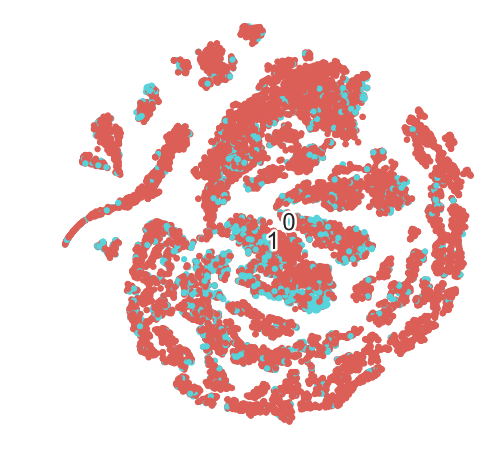

In [124]:
sepsis_scatter(sepsis_tsne, Y)

### Synthetic Minortiy Over-sampling Technique (SMOTE)

In [21]:
# Upsampling with SMOTE
sm = SMOTE(random_state = 42)
train_X_res, train_Y_res = sm.fit_sample(train_X, train_Y)

In [22]:
# Check before and after sampling
print('Before OverSampling, the shape of train_X: {}'.format(train_X.shape))
print('Before OverSampling, the shape of train_Y: {} \n'.format(train_Y.shape))
print("Before OverSampling, counts of label '1': {}".format(sum(train_Y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_Y==0)))

print('After OverSampling, the shape of train_X: {}'.format(train_X_res.shape))
print('After OverSampling, the shape of train_Y: {} \n'.format(train_Y_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(train_Y_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(train_Y_res==0)))

Before OverSampling, the shape of train_X: (12281, 45)
Before OverSampling, the shape of train_Y: (12281,) 

Before OverSampling, counts of label '1': 1374
Before OverSampling, counts of label '0': 10907 

After OverSampling, the shape of train_X: (21814, 45)
After OverSampling, the shape of train_Y: (21814,) 

After OverSampling, counts of label '1': 10907
After OverSampling, counts of label '0': 10907 



### Define functions

In [23]:
# Define the variable_importance function
def variable_importance(fit):
    """
    Purpose
    ----------
    Checks if model is fitted CART model then produces variable importance
    and respective indices in dictionary.

    Parameters
    ----------
    * fit:  Fitted model containing the attribute feature_importances_

    Returns
    ----------
    Dictionary containing arrays with importance score and index of columns
    ordered in descending order of importance.
    """
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [24]:
# Define the print_var_importance function
def print_var_importance(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on information gain for CART model.
    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns
    ----------
    Prints feature importance in descending order
    """
    print("Feature ranking:")

    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))

In [25]:
# Define the variable_importance_plot function
def variable_importance_plot(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(20, 20))

    plt.title('Feature importances for Random Forest Model')
    plt.barh(index,
             importance_desc,
             align="center",
             color = '#875FDB')
    plt.yticks(index,
               feature_space)
    
    plt.ylim(-1, 50)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

In [26]:
# define the create_conf_mat function
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

In [27]:
# Define the print_class_report function
def print_class_report(predictions, alg_name):
    """
    Purpose
    ----------
    Function helps automate the report generated by the
    sklearn package. Useful for multiple model comparison

    Parameters:
    ----------
    predictions: The predictions made by the algorithm used
    alg_name: String containing the name of the algorithm used
    
    Returns:
    ----------
    Returns classification report generated from sklearn. 
    """
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions, test_Y))

In [28]:
# Define the plot_roc_curve function
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
 
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
        \nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise
        
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()    

### Random Forests - Train models adjusting for class weight

In [50]:
# Instantiate model with 1000 decision trees
fit_rf = RandomForestClassifier(n_estimators = 500, class_weight = 'balanced', random_state = 42)

In [51]:
# Train the model on training data
fit_rf.fit(train_X, train_Y);

In [52]:
# Run the variable_importance function
var_imp_rf = variable_importance(fit_rf)

In [53]:
# Run the print_var_importance function
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']
names_index = list(X.columns.values)
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'apachescore' has a Mean Decrease in Impurity of 0.13657
2. The feature 'meanbp' has a Mean Decrease in Impurity of 0.05865
3. The feature 'heartrate' has a Mean Decrease in Impurity of 0.05376
4. The feature 'temperature' has a Mean Decrease in Impurity of 0.05248
5. The feature 'creatinine' has a Mean Decrease in Impurity of 0.05167
6. The feature 'respiratoryrate' has a Mean Decrease in Impurity of 0.04853
7. The feature 'glucose' has a Mean Decrease in Impurity of 0.04836
8. The feature 'wbc' has a Mean Decrease in Impurity of 0.04419
9. The feature 'bun' has a Mean Decrease in Impurity of 0.04398
10. The feature 'urine' has a Mean Decrease in Impurity of 0.04395
11. The feature 'hematocrit' has a Mean Decrease in Impurity of 0.04287
12. The feature 'sodium' has a Mean Decrease in Impurity of 0.03488
13. The feature 'ph' has a Mean Decrease in Impurity of 0.03308
14. The feature 'fio2' has a Mean Decrease in Impurity of 0.03194
15. The feature 'bilir

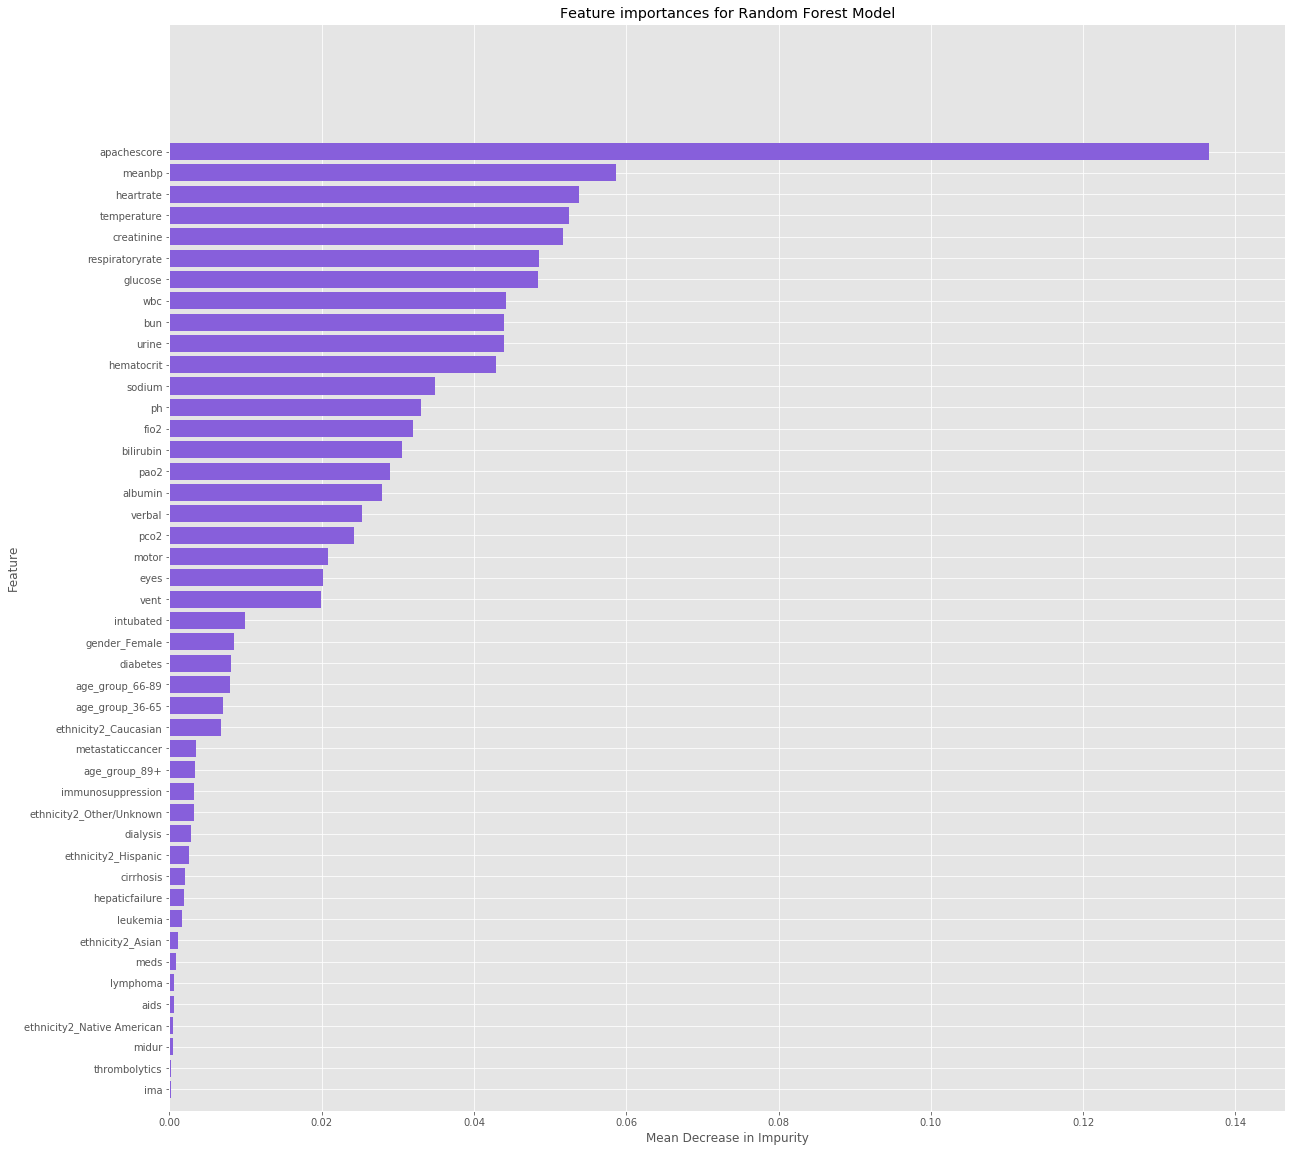

In [54]:
# Run the variable_importance_plot function
variable_importance_plot(importances_rf, indices_rf, names_index)

In [55]:
# predict the test data
predictions_rf = fit_rf.predict(test_X)

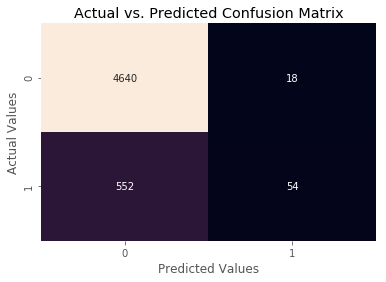

In [56]:
# Run the create_conf_mat function
conf_mat_rf = create_conf_mat(test_Y, predictions_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [57]:
# Run the print_class_report function
class_report_rf = print_class_report(predictions_rf, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      5192
           1       0.09      0.75      0.16        72

   micro avg       0.89      0.89      0.89      5264
   macro avg       0.54      0.82      0.55      5264
weighted avg       0.98      0.89      0.93      5264



In [58]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob_rf = fit_rf.predict_proba(test_X)[:, 1]
fpr2_rf, tpr2_rf, _ = roc_curve(test_Y,
                          predictions_prob_rf,
                          pos_label = 1)
auc_rf = auc(fpr2_rf, tpr2_rf)

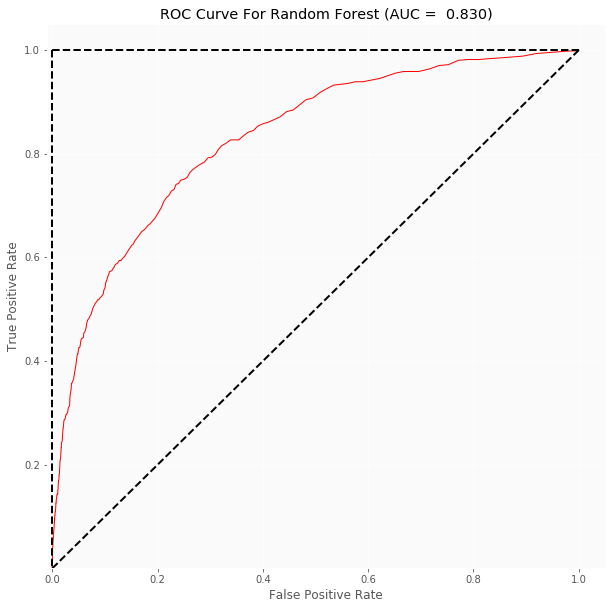

In [59]:
# Run the plot_roc_curve function
plot_roc_curve(fpr2_rf, tpr2_rf, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

### Random Forest - Train model after Upsampling

In [60]:
# Instantiate model with 1000 decision trees
fit_rf_res = RandomForestClassifier(n_estimators = 500, class_weight = 'balanced', random_state = 42)

In [61]:
# Train the model on training data
fit_rf_res.fit(train_X_res, train_Y_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)

In [62]:
# Run the variable_importance function
var_imp_rf_res = variable_importance(fit_rf_res)

In [63]:
# Run the print_var_importance function
importances_rf_res = var_imp_rf_res['importance']
indices_rf_res = var_imp_rf_res['index']
names_index = list(X.columns.values)
print_var_importance(importances_rf_res, indices_rf_res, names_index)

Feature ranking:
1. The feature 'vent' has a Mean Decrease in Impurity of 0.09763
2. The feature 'apachescore' has a Mean Decrease in Impurity of 0.08426
3. The feature 'motor' has a Mean Decrease in Impurity of 0.06678
4. The feature 'verbal' has a Mean Decrease in Impurity of 0.06412
5. The feature 'eyes' has a Mean Decrease in Impurity of 0.05681
6. The feature 'age_group_66-89' has a Mean Decrease in Impurity of 0.05252
7. The feature 'age_group_36-65' has a Mean Decrease in Impurity of 0.04384
8. The feature 'gender_Female' has a Mean Decrease in Impurity of 0.03835
9. The feature 'albumin' has a Mean Decrease in Impurity of 0.03230
10. The feature 'diabetes' has a Mean Decrease in Impurity of 0.03197
11. The feature 'bilirubin' has a Mean Decrease in Impurity of 0.02931
12. The feature 'temperature' has a Mean Decrease in Impurity of 0.02554
13. The feature 'meanbp' has a Mean Decrease in Impurity of 0.02522
14. The feature 'respiratoryrate' has a Mean Decrease in Impurity of 0.0

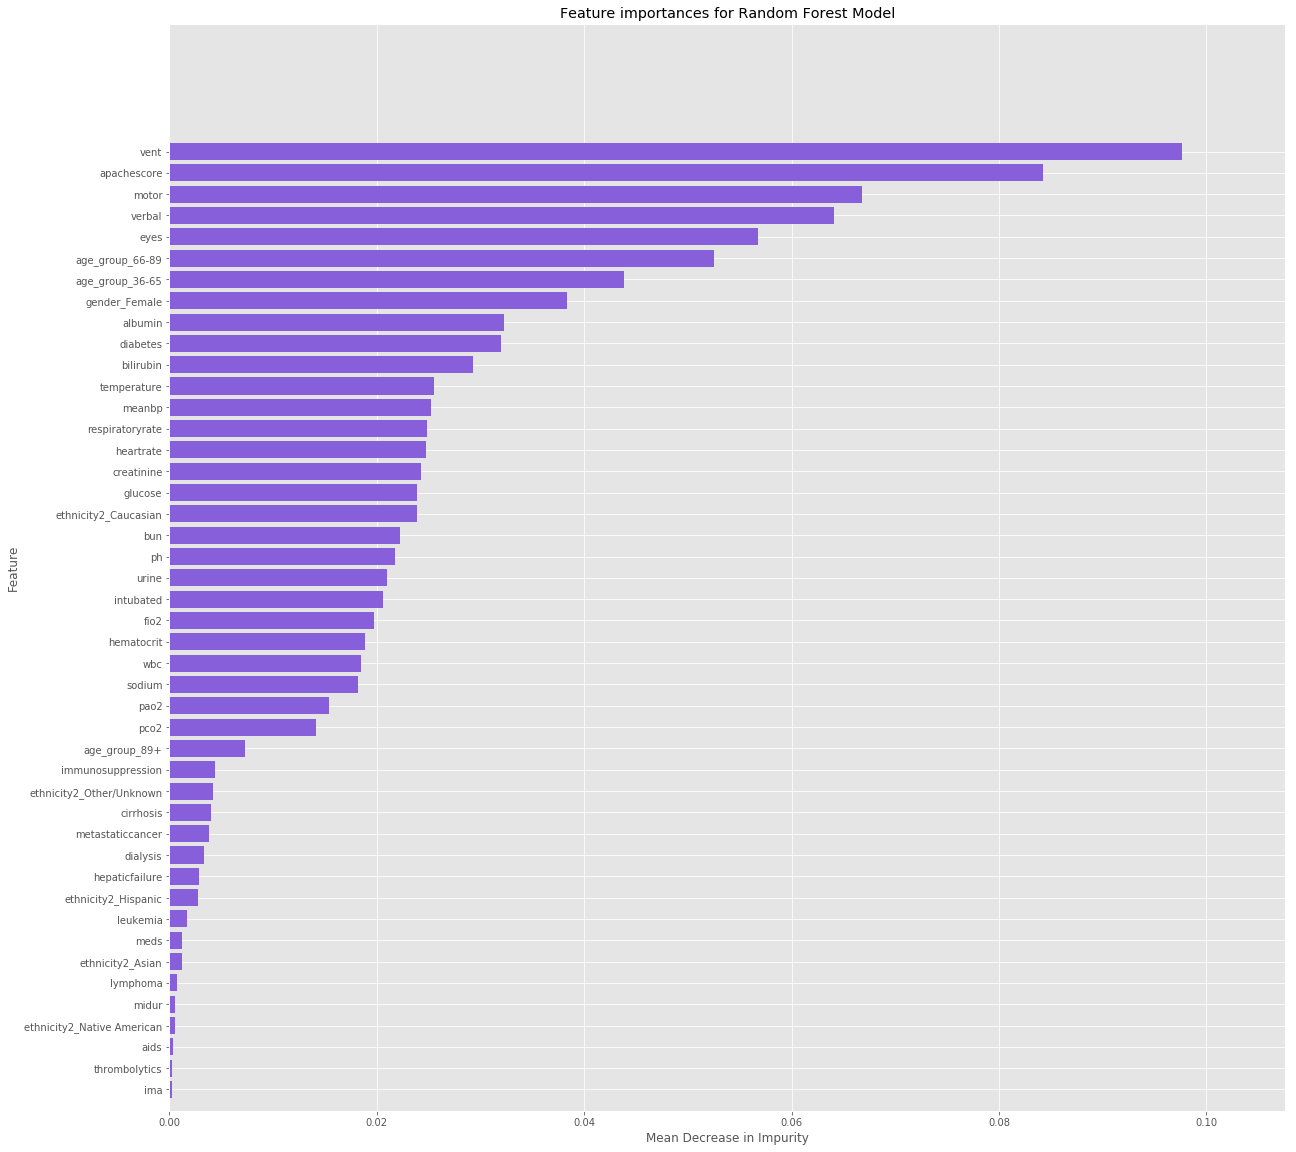

In [64]:
# Run the variable_importance_plot function
variable_importance_plot(importances_rf_res, indices_rf_res, names_index)

In [65]:
# predict the test data
predictions_rf_res = fit_rf_res.predict(test_X)

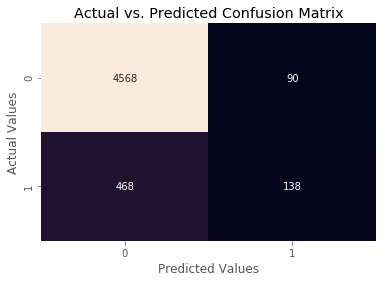

In [66]:
# Run the create_conf_mat function
conf_mat_rf_res = create_conf_mat(test_Y, predictions_rf_res)
sns.heatmap(conf_mat_rf_res, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [67]:
# Run the print_class_report function
class_report_rf_res = print_class_report(predictions_rf_res, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      5036
           1       0.23      0.61      0.33       228

   micro avg       0.89      0.89      0.89      5264
   macro avg       0.60      0.76      0.64      5264
weighted avg       0.95      0.89      0.92      5264



In [68]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob_rf_res = fit_rf_res.predict_proba(test_X)[:, 1]
fpr2_rf_res, tpr2_rf_res, _ = roc_curve(test_Y,
                          predictions_prob_rf_res,
                          pos_label = 1)
auc_rf_res = auc(fpr2_rf_res, tpr2_rf_res)

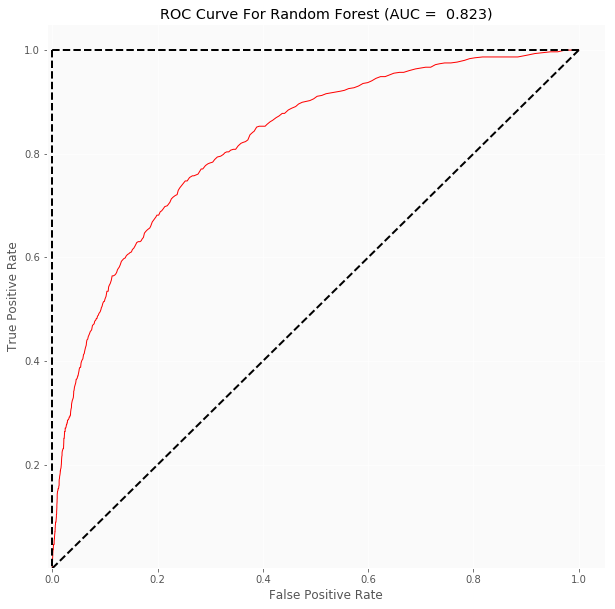

In [69]:
# Run the plot_roc_curve function
plot_roc_curve(fpr2_rf_res, tpr2_rf_res, auc_rf_res, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

### Logistic Regression - Statistical Inference

In [12]:
## Fit logistic regression
X_const = statm.add_constant(X)
logit_model = statm.Logit(Y, X_const)
logit_result = logit_model.fit()
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.278084
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           icumortality   No. Observations:                17545
Model:                          Logit   Df Residuals:                    17499
Method:                           MLE   Df Model:                           45
Date:                Tue, 29 Jan 2019   Pseudo R-squ.:                  0.2110
Time:                        10:25:13   Log-Likelihood:                -4879.0
converged:                       True   LL-Null:                       -6183.5
                                        LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.9484      0.309    -16.039      0.000      

### Logistic Regression  - Train models adjusting for class weight

In [81]:
# Instantiate model
fit_log = LogisticRegression(class_weight = 'balanced', random_state = 42)

In [82]:
# Train the model on training data
fit_log.fit(train_X, train_Y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [83]:
# predict the test data
predictions_log = fit_log.predict(test_X)

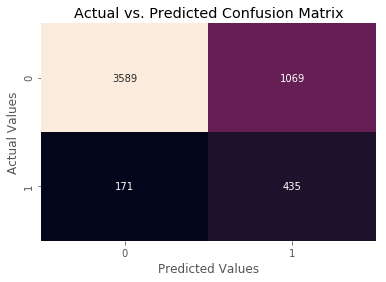

In [84]:
# Run the create_conf_mat function
conf_mat_log = create_conf_mat(test_Y, predictions_log)
sns.heatmap(conf_mat_log, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [85]:
# Run the print_class_report function
class_report_log = print_class_report(predictions_log, 'Logistic Regression')

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      3760
           1       0.72      0.29      0.41      1504

   micro avg       0.76      0.76      0.76      5264
   macro avg       0.74      0.62      0.63      5264
weighted avg       0.76      0.76      0.73      5264



In [86]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob_log = fit_log.predict_proba(test_X)[:, 1]
fpr2_log, tpr2_log, _ = roc_curve(test_Y,
                          predictions_prob_log,
                          pos_label = 1)
auc_rf_log = auc(fpr2_log, tpr2_log)

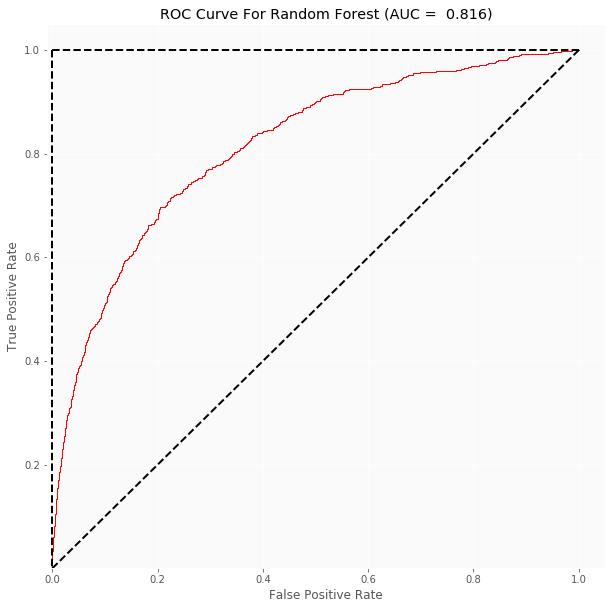

In [87]:
# Run the plot_roc_curve function
plot_roc_curve(fpr2_log, tpr2_log, auc_rf_log, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

### Logistic Regression - Train model after Upsampling

In [88]:
# Instantiate model
fit_log_res = LogisticRegression(class_weight = 'balanced', random_state = 42)

In [89]:
# Train the model on training data
fit_log_res.fit(train_X_res, train_Y_res);

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [90]:
# predict the test data
predictions_log_res = fit_log_res.predict(test_X)

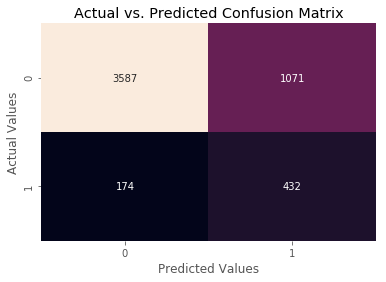

In [91]:
# Run the create_conf_mat function
conf_mat_log_res = create_conf_mat(test_Y, predictions_log_res)
sns.heatmap(conf_mat_log_res, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [92]:
# Run the print_class_report function
class_report_log_res = print_class_report(predictions_log_res, 'Logistic Regression')

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      3761
           1       0.71      0.29      0.41      1503

   micro avg       0.76      0.76      0.76      5264
   macro avg       0.74      0.62      0.63      5264
weighted avg       0.75      0.76      0.73      5264

